### Visualization
---

In [48]:
import sys

sys.path.append("..")
from preprocess.utils import TextConverter
from preprocess.data import TextDataForTC

from __future__ import print_function
import time, yaml, torch
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Feature Dim = 300
---

### 20ng-lstm
---

In [103]:
dataset = '20ng'
model = 'lstm'
with open('./doc_embeddings/{}_{}_doc_vectors.txt'.format(dataset, model), 'r') as f:
    doc_embed = f.readlines()

In [104]:
X = []
for s in doc_embed:
    X.append(s.split())

In [105]:
feat_cols = [ 'embed_dim_'+str(i) for i in range(len(X[0])-2) ]
meta_cols = ["doc_id", "label"]
df = pd.DataFrame(X,columns=meta_cols+feat_cols)
df[feat_cols] = df[feat_cols].astype(float)
df['label'] = df['label'].apply(lambda x: int(x.split(":")[1]))
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (7532, 402)


In [106]:
df_test = df[df.doc_id.str.contains('test')]

In [107]:
df_test.head()

,doc_id,label,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3,embed_dim_4,embed_dim_5,embed_dim_6,embed_dim_7,...,embed_dim_390,embed_dim_391,embed_dim_392,embed_dim_393,embed_dim_394,embed_dim_395,embed_dim_396,embed_dim_397,embed_dim_398,embed_dim_399
0,doc_test_id_0,2,-1.767031,-1.104802,0.437285,-0.580118,0.399753,-1.045103,-1.099608,-1.820596,...,-1.597024,-1.174957,0.380835,0.484270,-0.060674,0.459998,-0.650959,-0.139800,0.642676,0.847277
1,doc_test_id_1,10,-1.001275,-0.539317,-0.682750,-0.502597,-0.317110,-1.130020,-1.951645,-1.898431,...,-2.258945,0.159700,-0.011648,0.284811,0.130965,-1.947480,-0.399754,-1.015099,-0.379039,0.271312
2,doc_test_id_2,17,-0.241083,-0.596017,0.321471,-0.633747,-0.485248,-1.040725,-0.415947,-2.348852,...,-1.249686,-1.053508,0.404364,0.052216,-1.752174,-0.939235,-0.227065,0.059612,-1.204661,2.996486
3,doc_test_id_3,19,-1.109684,0.167382,0.313361,-1.171814,-1.180715,0.326694,-1.862410,-1.130105,...,-1.088969,-0.680362,-0.067078,-0.898913,-0.638518,-1.315731,-0.759923,-1.864668,-0.866538,0.508553
4,doc_test_id_4,3,-0.787290,0.152487,-0.405908,-0.619783,-0.541381,0.801625,-0.222177,-0.838739,...,-1.858301,-0.546375,-0.107091,0.492028,-0.656211,-1.682449,-0.189200,-1.678821,0.917153,0.587881


In [108]:
# Now lets only look at df_test
df = df_test.copy()
df.reset_index(drop=True, inplace=True)

#### PCA

In [109]:
df.head()

,doc_id,label,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3,embed_dim_4,embed_dim_5,embed_dim_6,embed_dim_7,...,embed_dim_390,embed_dim_391,embed_dim_392,embed_dim_393,embed_dim_394,embed_dim_395,embed_dim_396,embed_dim_397,embed_dim_398,embed_dim_399
0,doc_test_id_0,2,-1.767031,-1.104802,0.437285,-0.580118,0.399753,-1.045103,-1.099608,-1.820596,...,-1.597024,-1.174957,0.380835,0.484270,-0.060674,0.459998,-0.650959,-0.139800,0.642676,0.847277
1,doc_test_id_1,10,-1.001275,-0.539317,-0.682750,-0.502597,-0.317110,-1.130020,-1.951645,-1.898431,...,-2.258945,0.159700,-0.011648,0.284811,0.130965,-1.947480,-0.399754,-1.015099,-0.379039,0.271312
2,doc_test_id_2,17,-0.241083,-0.596017,0.321471,-0.633747,-0.485248,-1.040725,-0.415947,-2.348852,...,-1.249686,-1.053508,0.404364,0.052216,-1.752174,-0.939235,-0.227065,0.059612,-1.204661,2.996486
3,doc_test_id_3,19,-1.109684,0.167382,0.313361,-1.171814,-1.180715,0.326694,-1.862410,-1.130105,...,-1.088969,-0.680362,-0.067078,-0.898913,-0.638518,-1.315731,-0.759923,-1.864668,-0.866538,0.508553
4,doc_test_id_4,3,-0.787290,0.152487,-0.405908,-0.619783,-0.541381,0.801625,-0.222177,-0.838739,...,-1.858301,-0.546375,-0.107091,0.492028,-0.656211,-1.682449,-0.189200,-1.678821,0.917153,0.587881


In [110]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [111]:
N = min(10000, df.shape[0])
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.07918793 0.062511   0.05023689]


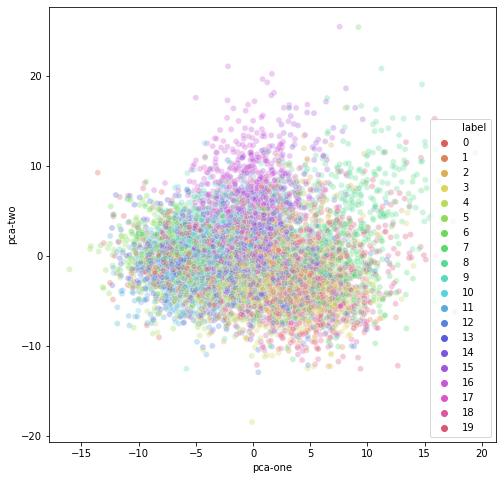

In [112]:
# 2d
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", df_subset.label.nunique()),
    data=df_subset.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

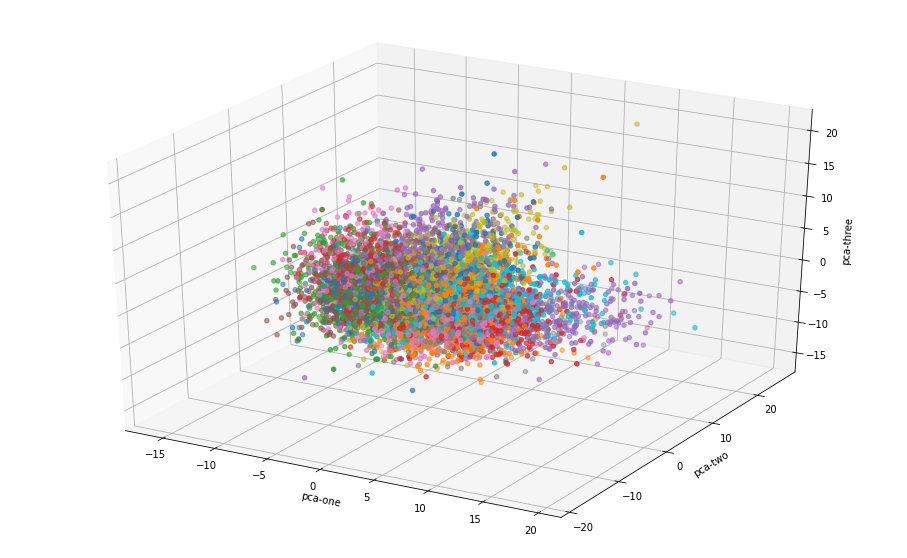

In [113]:
# 3d
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset.loc[rndperm,:]["pca-one"], 
    ys=df_subset.loc[rndperm,:]["pca-two"], 
    zs=df_subset.loc[rndperm,:]["pca-three"], 
    c=df_subset.loc[rndperm,:]["label"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

#### TSNE

In [114]:
np.random.seed(42)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7532 samples in 0.241s...
[t-SNE] Computed neighbors for 7532 samples in 38.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7532
[t-SNE] Computed conditional probabilities for sample 2000 / 7532
[t-SNE] Computed conditional probabilities for sample 3000 / 7532
[t-SNE] Computed conditional probabilities for sample 4000 / 7532
[t-SNE] Computed conditional probabilities for sample 5000 / 7532
[t-SNE] Computed conditional probabilities for sample 6000 / 7532
[t-SNE] Computed conditional probabilities for sample 7000 / 7532
[t-SNE] Computed conditional probabilities for sample 7532 / 7532
[t-SNE] Mean sigma: 4.269247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.292709
[t-SNE] KL divergence after 300 iterations: 2.913574


Text(0.5, 1.0, 'LSTM - 20ng - TSNE')

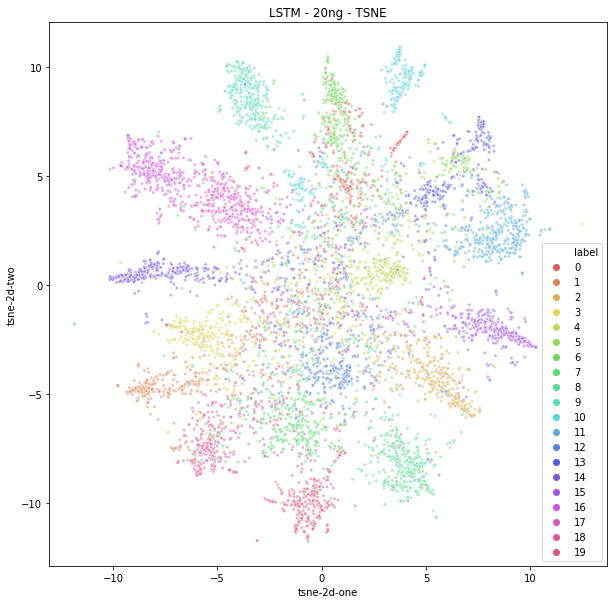

In [115]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset2 = df_subset#[df_subset['tsne-2d-two']]

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", df_subset2.label.nunique()),
    data=df_subset2,
    legend="full",
    alpha=0.5,
    s=10
)
plt.title("LSTM - 20ng - TSNE")

#### Combined

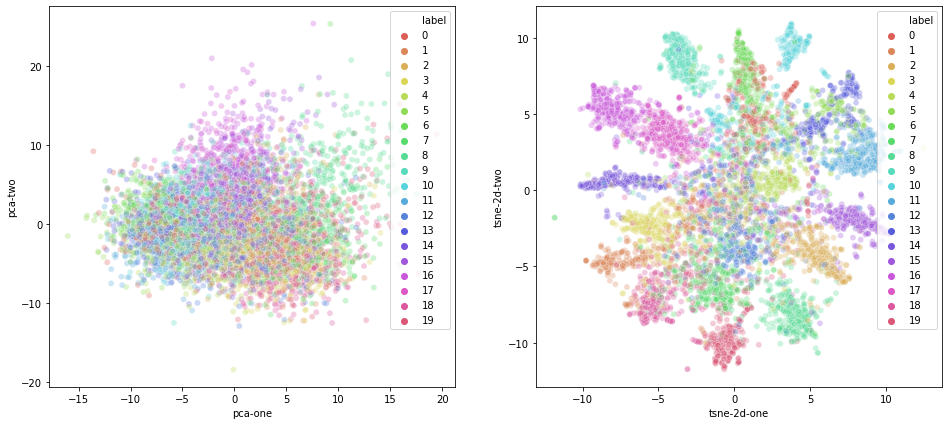

In [62]:
n_class = df_subset2.label.nunique()
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", n_class),
    data=df_subset2,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", n_class),
    data=df_subset2,
    legend="full",
    alpha=0.3,
    ax=ax2
)

#### Attention Weights

In [163]:
dataset = '20ng'
model = 'lstm'
attn_obj = torch.load('./doc_embeddings/{}_{}_attn_obj.pt'.format(dataset, model))
texts = attn_obj['texts']
labels = attn_obj['labels']
seq_lens = attn_obj['seq_lens']
attns = attn_obj['attns']

In [164]:
def plot_attention_weights(i, texts, labels, seq_lens, attns, max_tokens=80):
    seq_len = seq_lens[i]
    raw_sent = texts[i]
    sent = ' '.join(raw_sent.split()[:seq_len])
    attn = np.array(attns[i][:seq_len])
    label = labels[i]
    df = pd.DataFrame({'text': sent.split(), 'attn': attn}).iloc[:max_tokens]
    fig = plt.figure(figsize=(16,0.2), tight_layout=True)
    sns.heatmap(df['attn'].values.reshape(1,-1), 
                xticklabels=df['text'].values,
                yticklabels=['attn'],
                cmap='coolwarm')
    plt.title("label: {}".format(label))
    return fig

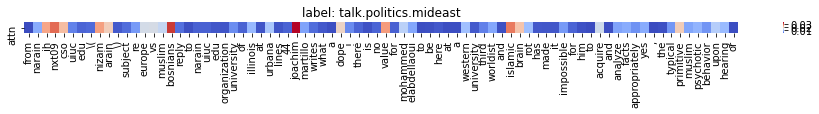

In [165]:
fig = plot_attention_weights(1, texts, labels, seq_lens, attns, max_tokens=80)

<ipython-input-166-bbfe1654c794>:2: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.savefig("./grapics.png")


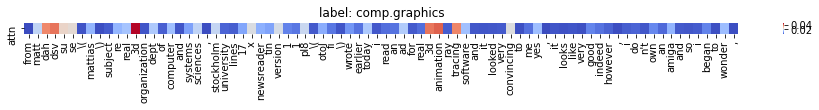

In [166]:
fig = plot_attention_weights(4, texts, labels, seq_lens, attns, max_tokens=80)
fig.savefig("./grapics.png")

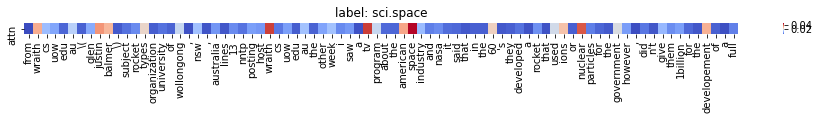

In [167]:
fig = plot_attention_weights(12, texts, labels, seq_lens, attns, max_tokens=80)

### 20ng-transformer
---

In [68]:
dataset = '20ng'
model = 'transformer'
with open('./doc_embeddings/{}_{}_doc_vectors.txt'.format(dataset, model), 'r') as f:
    doc_embed = f.readlines()

In [69]:
X = []
for s in doc_embed:
    X.append(s.split())

In [70]:
feat_cols = [ 'embed_dim_'+str(i) for i in range(len(X[0])-2) ]
meta_cols = ["doc_id", "label"]
df = pd.DataFrame(X,columns=meta_cols+feat_cols)
df[feat_cols] = df[feat_cols].astype(float)
df['label'] = df['label'].apply(lambda x: int(x.split(":")[1]))
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (7532, 302)


In [71]:
df_test = df[df.doc_id.str.contains('test')]

In [72]:
df_test.head()

,doc_id,label,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3,embed_dim_4,embed_dim_5,embed_dim_6,embed_dim_7,...,embed_dim_290,embed_dim_291,embed_dim_292,embed_dim_293,embed_dim_294,embed_dim_295,embed_dim_296,embed_dim_297,embed_dim_298,embed_dim_299
0,doc_test_id_0,2,-0.354868,-0.397134,-0.382139,-0.159596,0.706897,-0.138606,-0.346330,0.141628,...,0.022572,0.010212,-0.402432,0.088223,-0.363866,0.417075,0.142038,0.505426,0.136338,-0.895984
1,doc_test_id_1,10,-0.168912,-0.160862,-0.614770,0.040377,0.253237,-0.365429,-0.307698,0.243008,...,-0.283023,-0.068431,-0.253128,-0.063779,-0.189989,0.153473,0.122357,0.609539,-0.072155,-0.457120
2,doc_test_id_2,17,-0.169370,-0.765487,-0.302652,0.586300,0.317548,-0.178801,-0.008781,0.279826,...,0.038714,0.171693,-0.604372,0.101138,0.172652,0.088445,0.294775,0.599955,0.000460,-0.581075
3,doc_test_id_3,19,0.011079,-0.532771,-0.412291,0.116907,0.079651,-0.369672,-0.001228,0.090238,...,0.308449,0.120392,-0.243385,0.038495,0.085855,-0.097509,-0.040175,0.463219,0.007783,-0.297391
4,doc_test_id_4,3,-0.033289,-0.363734,-0.172897,0.091253,0.458430,-0.110091,-0.174084,0.389245,...,0.215112,0.146116,-0.491280,-0.137449,0.009518,0.295082,-0.181149,0.404769,0.041726,-0.600885


In [73]:
# Now lets only look at df_test
df = df_test.copy()
df.reset_index(drop=True, inplace=True)

#### PCA

In [74]:
df.head()

,doc_id,label,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3,embed_dim_4,embed_dim_5,embed_dim_6,embed_dim_7,...,embed_dim_290,embed_dim_291,embed_dim_292,embed_dim_293,embed_dim_294,embed_dim_295,embed_dim_296,embed_dim_297,embed_dim_298,embed_dim_299
0,doc_test_id_0,2,-0.354868,-0.397134,-0.382139,-0.159596,0.706897,-0.138606,-0.346330,0.141628,...,0.022572,0.010212,-0.402432,0.088223,-0.363866,0.417075,0.142038,0.505426,0.136338,-0.895984
1,doc_test_id_1,10,-0.168912,-0.160862,-0.614770,0.040377,0.253237,-0.365429,-0.307698,0.243008,...,-0.283023,-0.068431,-0.253128,-0.063779,-0.189989,0.153473,0.122357,0.609539,-0.072155,-0.457120
2,doc_test_id_2,17,-0.169370,-0.765487,-0.302652,0.586300,0.317548,-0.178801,-0.008781,0.279826,...,0.038714,0.171693,-0.604372,0.101138,0.172652,0.088445,0.294775,0.599955,0.000460,-0.581075
3,doc_test_id_3,19,0.011079,-0.532771,-0.412291,0.116907,0.079651,-0.369672,-0.001228,0.090238,...,0.308449,0.120392,-0.243385,0.038495,0.085855,-0.097509,-0.040175,0.463219,0.007783,-0.297391
4,doc_test_id_4,3,-0.033289,-0.363734,-0.172897,0.091253,0.458430,-0.110091,-0.174084,0.389245,...,0.215112,0.146116,-0.491280,-0.137449,0.009518,0.295082,-0.181149,0.404769,0.041726,-0.600885


In [75]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [76]:
N = min(10000, df.shape[0])
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.05420035 0.04415992 0.0402713 ]


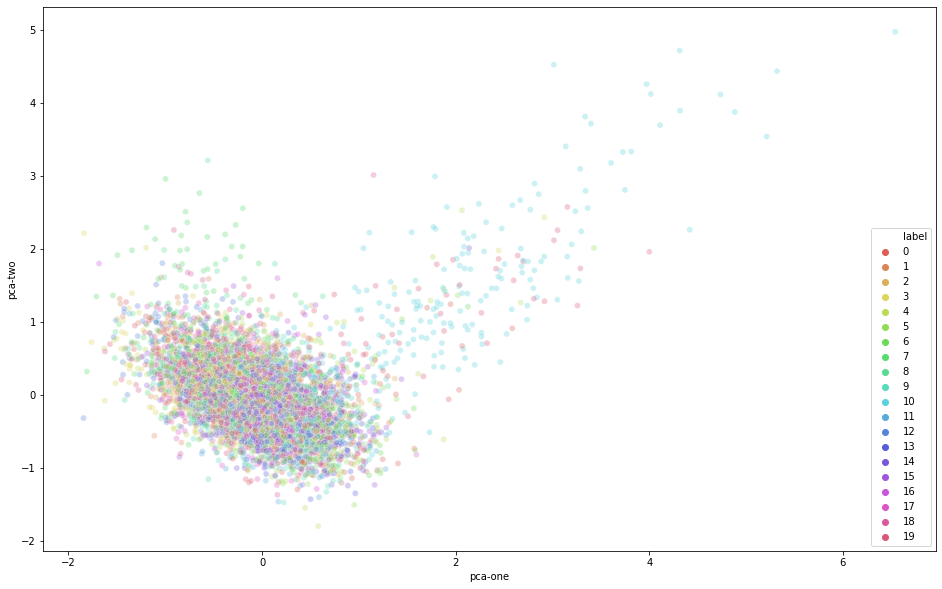

In [77]:
# 2d
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", df_subset.label.nunique()),
    data=df_subset.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

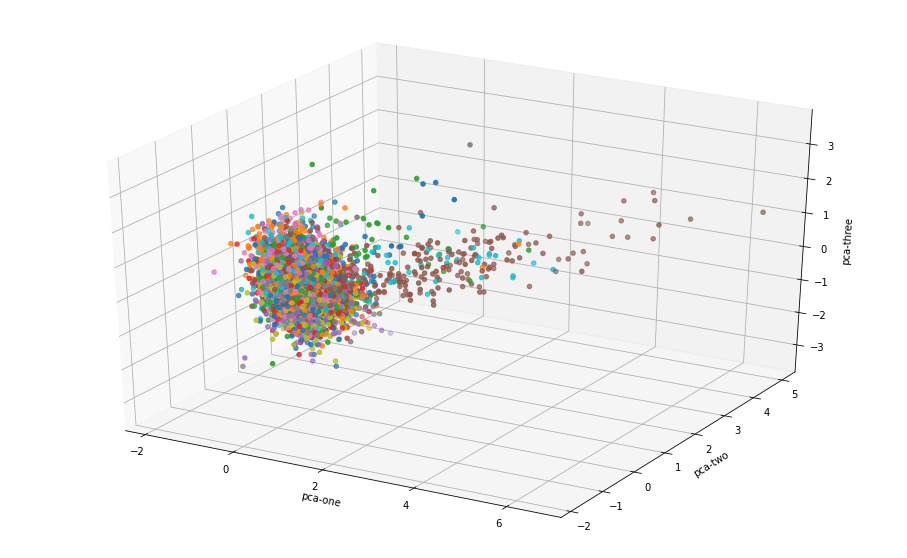

In [78]:
# 3d
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset.loc[rndperm,:]["pca-one"], 
    ys=df_subset.loc[rndperm,:]["pca-two"], 
    zs=df_subset.loc[rndperm,:]["pca-three"], 
    c=df_subset.loc[rndperm,:]["label"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

#### TSNE

In [79]:
np.random.seed(11747)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=500)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 7532 samples in 0.112s...
[t-SNE] Computed neighbors for 7532 samples in 29.482s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7532
[t-SNE] Computed conditional probabilities for sample 2000 / 7532
[t-SNE] Computed conditional probabilities for sample 3000 / 7532
[t-SNE] Computed conditional probabilities for sample 4000 / 7532
[t-SNE] Computed conditional probabilities for sample 5000 / 7532
[t-SNE] Computed conditional probabilities for sample 6000 / 7532
[t-SNE] Computed conditional probabilities for sample 7000 / 7532
[t-SNE] Computed conditional probabilities for sample 7532 / 7532
[t-SNE] Mean sigma: 0.773690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.646400
[t-SNE] KL divergence after 500 iterations: 2.504460


Text(0.5, 1.0, 'Transformer - 20ng - TSNE')

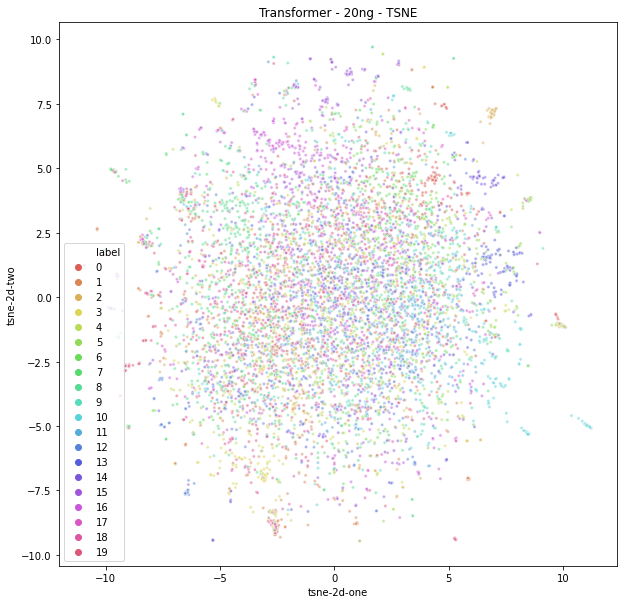

In [94]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset2 = df_subset # [df_subset['tsne-2d-two'] < 15]

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", df_subset2.label.nunique()),
    data=df_subset2,
    legend="full",
    alpha=0.5,
    s=10
)
plt.title("Transformer - 20ng - TSNE")

#### Combined

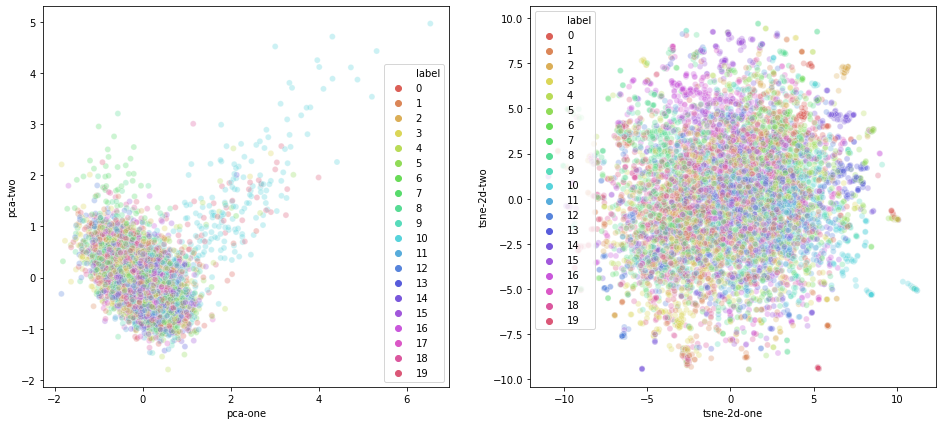

In [81]:
n_class = df_subset2.label.nunique()
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", n_class),
    data=df_subset2,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", n_class),
    data=df_subset2,
    legend="full",
    alpha=0.3,
    ax=ax2
)

#### Attention Weights

In [134]:
dataset = '20ng'
model = 'transformer'
attn_obj = torch.load('./doc_embeddings/{}_{}_attn_obj.pt'.format(dataset, model))
texts = attn_obj['texts']
labels = np.array(attn_obj['labels'])
seq_lens = attn_obj['seq_lens']
ids = np.array(attn_obj['doc_test_ids'])
preds = np.array(attn_obj['preds'])
attns = attn_obj['attns']['attn_weight']
tfmr_attn_layer0 = attn_obj['attns']['tfmr_layer_0']
tfmr_attn_layer1 = attn_obj['attns']['tfmr_layer_1']

In [151]:
def plot_attention_weights(i, texts, labels, seq_lens, attns, max_tokens=80):
    seq_len = seq_lens[i]
    raw_sent = texts[i]
    sent = ' '.join(raw_sent.split()[:seq_len])
    attn = np.array(attns[i][:seq_len])
    label = labels[i]
    df = pd.DataFrame({'text': sent.split(), 'attn': attn}).iloc[:max_tokens]
    fig = plt.figure(figsize=(16,0.2))
    sns.heatmap(df['attn'].values.reshape(1,-1), 
                xticklabels=df['text'].values,
                yticklabels=['attn'],
                cmap='coolwarm')
    plt.title("label: {}".format(label))

In [152]:
ids[preds == labels][:15]

array(['doc_test_id_3', 'doc_test_id_4', 'doc_test_id_5', 'doc_test_id_7',
       'doc_test_id_8', 'doc_test_id_9', 'doc_test_id_10',
       'doc_test_id_11', 'doc_test_id_12', 'doc_test_id_13',
       'doc_test_id_14', 'doc_test_id_15', 'doc_test_id_16',
       'doc_test_id_17', 'doc_test_id_19'], dtype='<U16')

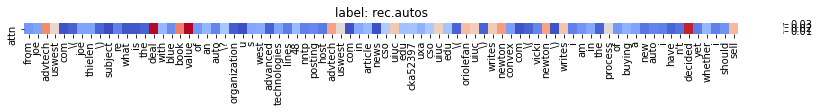

In [153]:
plot_attention_weights(16, texts, labels, seq_lens, attns, max_tokens=80)

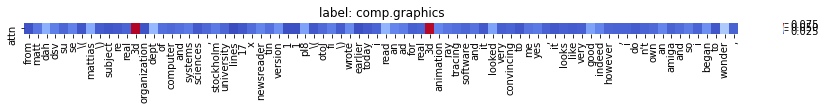

In [154]:
plot_attention_weights(4, texts, labels, seq_lens, attns, max_tokens=80)

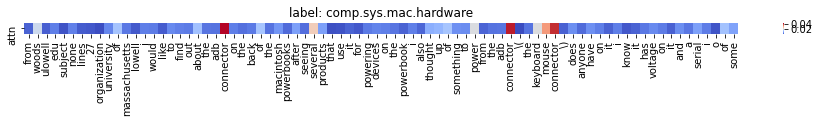

In [155]:
plot_attention_weights(9, texts, labels, seq_lens, attns, max_tokens=80)

In [156]:
tfmr_attn_layer1[9]

tensor([[0.0017, 0.0168, 0.0170,  ..., 0.0021, 0.0121, 0.0293],
        [0.0006, 0.0311, 0.0265,  ..., 0.0008, 0.0055, 0.0253],
        [0.0068, 0.0058, 0.0134,  ..., 0.0104, 0.0073, 0.0121],
        ...,
        [0.0021, 0.0386, 0.0175,  ..., 0.0006, 0.0094, 0.0090],
        [0.0037, 0.0177, 0.0373,  ..., 0.0026, 0.0147, 0.0096],
        [0.0037, 0.0116, 0.0212,  ..., 0.0027, 0.0154, 0.0178]])

Text(0.5, 1.0, 'label: rec.autos')

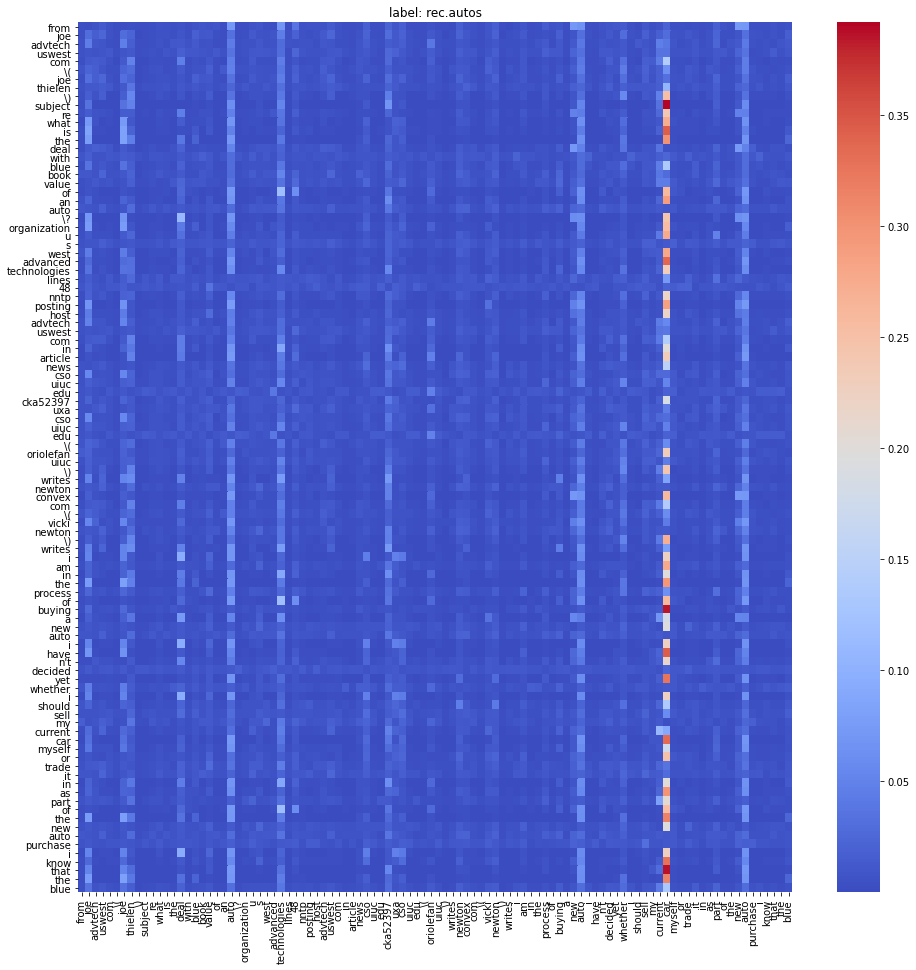

In [157]:
i=16
fig = plt.figure(figsize = (16,16))
sns.heatmap(tfmr_attn_layer1[i].numpy(), 
            xticklabels=texts[i].split(),
            yticklabels=texts[i].split(),
            cmap='coolwarm')
plt.title('label: {}'.format(labels[i]))

#### Politics example
This the following example, we can see the model perceives the word 'rot' should be focused on to classify the text as 'talk.politics.mideast'. We further selected what has the self-attention layer looked at at this word. Among the rest, the salient tokens include joachim, matillo, worldist, muslim, bosnians, words that tends to be more correlated to the topic than the rest.

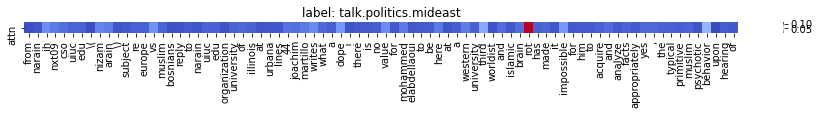

In [158]:
i=1
plot_attention_weights(i, texts, labels, seq_lens, attns, max_tokens=80)

'from narain ih nxt09 cso uiuc edu \\( nizam arain \\) subject re europe vs muslim bosnians reply to narain uiuc edu organization university of illinois at urbana lines 44 joachim martillo writes what a dope ! there is no value for mohammed elabdellaoui to be here at a western university third worldist and islamic brain rot has made it impossible for him to acquire and analyze facts appropriately yes , the typical primitive muslim psychotic behavior upon hearing or reading a fact start whining about the jews what a jerk you should go back to your mindlessly stupid 3rd'

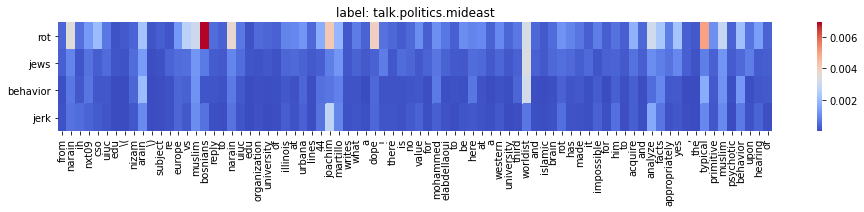

In [159]:
topk = 4
max_tokens=80
max_saliency_idx = np.array(attns[i]).argsort()[-topk:][::-1]
seq_len = seq_lens[i]
tokens = np.array(texts[i].split()[:seq_len])
fig = plt.figure(figsize = (16,2))
matrix = tfmr_attn_layer1[i].numpy()[max_saliency_idx].reshape(topk,-1)
weights = np.array(attns[i])[max_saliency_idx]
matrix = matrix * weights.reshape(-1,1) # weigh self attention with attention weights
sns.heatmap(matrix[:, :min(seq_len, max_tokens)], 
            xticklabels=tokens[:max_tokens],
            yticklabels=tokens[max_saliency_idx],
            cmap='coolwarm')
plt.title('label: {}'.format(labels[i]))
texts[i]

#### Graphics Example

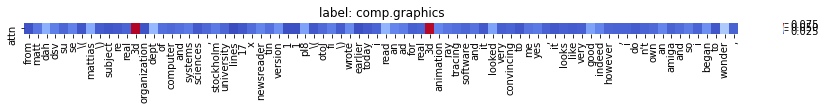

In [160]:
i=4
plot_attention_weights(i, texts, labels, seq_lens, attns, max_tokens=80)

"from matt dah dsv su se \\( mattias \\) subject re real 3d organization dept of computer and systems sciences , stockholm university lines 17 x newsreader tin version 1 1 pl8 \\( otol fi \\) wrote earlier today i read an ad for real 3d animation ray tracing software and it looked very convincing to me yes , it looks like very good indeed however , i do n't own an amiga and so i began to wonder , if there 's a pc version of it nope regards email mattias matt dah dsv su se i love it"

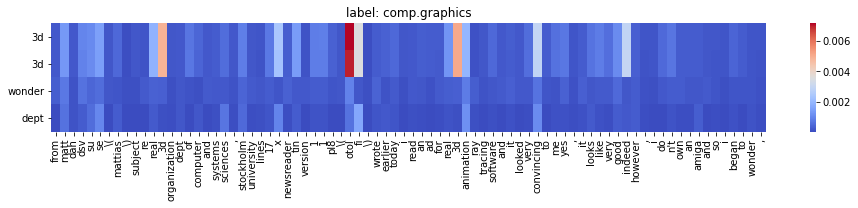

In [161]:
topk = 4
max_tokens=80
max_saliency_idx = np.array(attns[i]).argsort()[-topk:][::-1]
seq_len = seq_lens[i]
tokens = np.array(texts[i].split()[:seq_len])
fig = plt.figure(figsize = (16,2))
matrix = tfmr_attn_layer1[i].numpy()[max_saliency_idx].reshape(topk,-1)
weights = np.array(attns[i])[max_saliency_idx]
matrix = matrix * weights.reshape(-1,1) # weigh self attention with attention weights
sns.heatmap(matrix[:, :min(seq_len, max_tokens)], 
            xticklabels=tokens[:max_tokens],
            yticklabels=tokens[max_saliency_idx],
            cmap='coolwarm')
plt.title('label: {}'.format(labels[i]))
texts[i]

#### sci.electronics Example

'from noeler xanth cs orst edu \\( eric richard noel \\) subject re how to the disks copy protected article i d flop 1r76sbinnkap organization oregon state university lines 28 nntp posting host xanth cs orst edu hey , now will you stop encouraging him \\? copy protection only serves one pur pose to keep the honest buyer from making \\( legal \\) backup copies it will definitely not stop any pirates if you want to protect you soft , supply a good documentation and support this is imho the only way of effectively pro software best regards , arno'

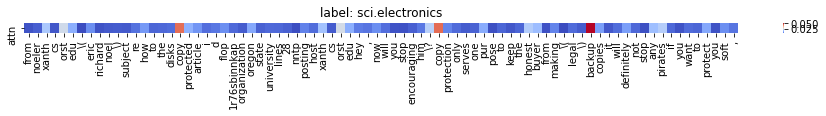

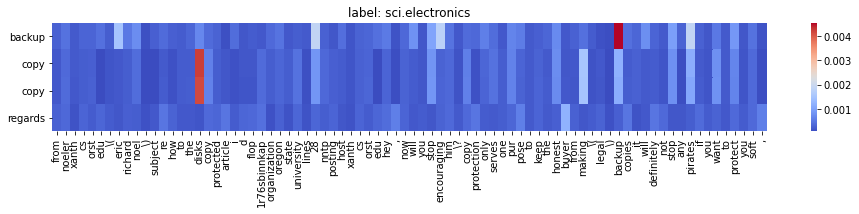

In [162]:
i=14
plot_attention_weights(i, texts, labels, seq_lens, attns, max_tokens=80)

topk = 4
max_tokens=80
max_saliency_idx = np.array(attns[i]).argsort()[-topk:][::-1]
seq_len = seq_lens[i]
tokens = np.array(texts[i].split()[:seq_len])
fig = plt.figure(figsize = (16,2))
matrix = tfmr_attn_layer1[i].numpy()[max_saliency_idx].reshape(topk,-1)
weights = np.array(attns[i])[max_saliency_idx]
matrix = matrix * weights.reshape(-1,1) # weigh self attention with attention weights
sns.heatmap(matrix[:, :min(seq_len, max_tokens)], 
            xticklabels=tokens[:max_tokens],
            yticklabels=tokens[max_saliency_idx],
            cmap='coolwarm')
plt.title('label: {}'.format(labels[i]))
texts[i]